In [1]:
import os
import warnings
import time
from copy import deepcopy
from glob import glob
import pickle

import numpy as np 

from scipy.stats import chisquare
from scipy.interpolate import interp1d, interp2d

from astropy.io import fits
from astropy.stats import sigma_clipped_stats, sigma_clip
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve, Gaussian2DKernel
from astropy import units as u 
from astropy.nddata import CCDData, Cutout2D
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.coordinates import SkyCoord
from astropy.utils.data import download_file

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties, SourceProperties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus
from photutils.isophote import EllipseGeometry, Ellipse

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['image.origin'] = 'lower'

In [7]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [25]:
acs_filter_list = ['f435w', 'f606w', 'f814w']
wfc3_filter_list = ['f105w', 'f125w', 'f140w', 'f160w']

input_data_formatter = "https://archive.stsci.edu/pub/hlsp/clash/rxj1347/data/hst/scale_65mas/hlsp_clash_hst_{}_rxj1347_{}_v1_drz.fits"
data_paths = {}
for f in acs_filter_list:
    data_paths[f] = input_data_formatter.format('acs', f)
    
for f in wfc3_filter_list:
    data_paths[f] = input_data_formatter.format('wfc3ir', f)
    


# User Inputs

In [26]:
show_plots = True

min_z = 0
max_z = 1

arcsec_cutoff = 0.5 #1 * 60/1000 # pixels * conversion

# Dark patch:
# A dark patch in the image to measure background stats
noise_cutout_center = (2343, 1888)
noise_cutout_size = 70

# Center of cluster:
cx, cy = [2508, 2525]
data_cutout_size = 3000

# Import Image (for plots)

In [27]:
# redo = False 
# if os.path.isfile('combined_data.fits') and not redo:
#     combined_data = CCDData.read('combined_data.fits')
# else:
#     combined_data = None
#     combined_wht = None 

#     for current_filter in wfc3_filter_list:
#         print(current_filter)

#         input_data_path = data_paths[current_filter]
#         input_wht_path = data_paths[current_filter].replace("drz.fits", "wht.fits")

#         print("Load Data")
#         data = CCDData.read(input_data_path)

#         print("Load Wht")
#         wht = CCDData.read(input_wht_path, unit=u.electron/u.count)
        
#         combined_header = data.header 

#         if combined_data is None:
#             combined_data = data.data * wht.data 
#             combined_wht = wht.data  
#         else:
#             combined_data += data.data  * wht.data  
#             combined_wht += wht.data  

#     combined_data /= combined_wht

#     combined_data = CCDData(combined_data, unit=u.electron/u.count, wcs=data.wcs)
#     combined_data.write('combined_data.fits')

In [34]:
detection_filter = 'f160w'
input_data_path = data_paths[detection_filter]
combined_data = CCDData.read(input_data_path, cache=True)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
        Incon

In [35]:
input_data_path

'https://archive.stsci.edu/pub/hlsp/clash/rxj1347/data/hst/scale_65mas/hlsp_clash_hst_wfc3ir_rxj1347_f160w_v1_drz.fits'

### Cutout Detection Image

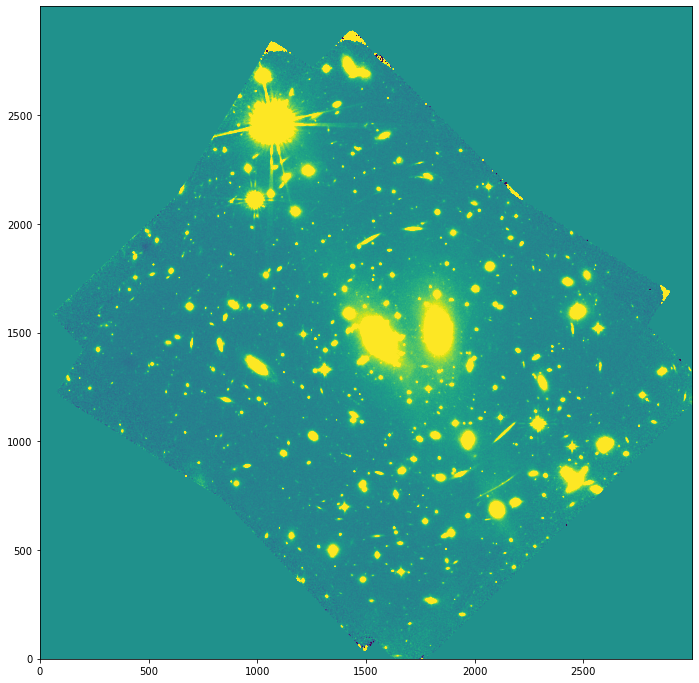

In [36]:
combined_image = Cutout2D(combined_data, (cx, cy), data_cutout_size, copy=True)

# Compute image stats
combined_image_min = combined_image.data.min()
combined_image_max = combined_image.data.max()
combined_image_mean = combined_image.data.mean()
combined_image_sigma = combined_image.data.std()
combined_image_3_sigma = combined_image_sigma * 3.
combined_image_8_sigma = combined_image_sigma * 8.

combined_image_clipped_mean, combined_image_clipped_median, combined_image_clipped_std = sigma_clipped_stats(combined_image.data, sigma=3.0)

# Subtract Noise
combined_image.data  -= combined_image_clipped_mean

# Set min and max values for all plots
vmin = -10 * combined_image_clipped_std
vmax = +10 * combined_image_clipped_std

if show_plots:
    plt.imshow(combined_image.data, vmin=vmin, vmax=vmax)
    plt.show()

#print(image_mean)

# Photomerty Catalog

In [37]:
robel_cat_path = 'hlsp_clash_hst_rxj1347_v1_drz_petrosian_catalog.csv'
robel_cat = Table.read(robel_cat_path)

In [38]:
# init redshift array 
redshifts = np.zeros(len(robel_cat))
redshifts[:] = np.nan

quality = np.zeros(len(robel_cat))

#  Z Catalogs

### Glass

```
# ============ GLASS Redshift Catalog for A2744 ============
# For information on the data refer to
# Team Page:    http://glass.physics.ucsb.edu/
# Data access:  https://archive.stsci.edu/prepds/glass/
#
# When using data from GLASS please cite:
# - Treu et al. 2015, ApJ, 812, 114
# - Schmidt et al. 2014, ApJL, 782, 36
#
# ID                            The GLASS IDs.
#                               IDs on the format 0xxxx refer to the publicly
#                               available GLASS v001 data release available at
#                               https://archive.stsci.edu/prepds/glass/
# RA                            Right ascension of object in degrees
# DEC                           Declination of object in degrees
# redshift                      The GLASS redshift assigned from visual inspection
#                               (using GiGz: https://github.com/kasperschmidt/GLASSinspectionGUIs)
#                               of the individual GLASS spectra and the automatic redshift fits
#                               to these combined with the CLASH photometry.
# redshift_quality              The redshift quality from the GiGz inspections
#                               Redshift are rated as: 0) no z 1) tentative 2) possible
#                                                      3) probable 4) secure
#                               Fractional qualities come from the combination of multiple
#                               redshift inspections.
# multiple_redshift_solutions   Flag indicating potential multiple redshifts, i.e., if a single
#                               emission line was not uniquely determined the redshift depends
#                               on the line identification.
#                               Fractional values come from the combination of multiple
#                               visual inspections
#

# The data are available in the main *_obj*24.tar.gz tar ball from https://archive.stsci.edu/prepds/glass/.
# = = = = = = = = = = = = = = = = = = = =
# ID   RA    DEC   redshift  redshift_quality   multiple_redshift_solutions
```

In [39]:
# GLASS
glass_catalog_path = "https://archive.stsci.edu/missions/hlsp/glass/rxj1347/hlsp_glass_hst_wfc3_rxj1347-fullfov-pa999_ir_v001_redshiftcatalog.txt"
glass_catalog_name = "GLASS"

glass_ra_kwrd = "RA"
glass_dec_kwrd = "DEC"
glass_z_kwrd = "redshift"
glass_quality_kwrd = "redshift_quality"

# Download and make Table
download_path = download_file(glass_catalog_path)
with open(download_path) as f:
    txt_header = None
    txt_data = []
    for line in f:
        line = line.replace("\n", "")
        if line[0] == "#":
            txt_header = line[1:].split()
        else:
            txt_row = line.split()[:len(txt_header)]
            txt_row = np.array([float(i) for i in txt_row])
            assert len(txt_row) == len(txt_header)
            
            txt_data.append(txt_row)
    txt_data = np.array(txt_data)
raw_glass_catalog = Table(data=txt_data, names=txt_header)

print("{}: {}".format(glass_catalog_name, len(raw_glass_catalog)))

GLASS: 256


In [40]:
# Filter redshifts
glass_catalog_mask = np.ones((len(raw_glass_catalog))).astype(bool)

glass_catalog_mask = glass_catalog_mask & (raw_glass_catalog[glass_z_kwrd] > min_z).astype(bool).data  
glass_catalog_mask = glass_catalog_mask & (raw_glass_catalog[glass_z_kwrd] < max_z).astype(bool).data 
glass_catalog_mask = glass_catalog_mask & (raw_glass_catalog[glass_z_kwrd] != 0).astype(bool).data 

glass_catalog = raw_glass_catalog[glass_catalog_mask]
print(len(glass_catalog))

63


In [41]:
# Coords 
glass_ra, glass_dec = glass_catalog[glass_ra_kwrd], glass_catalog[glass_dec_kwrd]
glass_x, glass_y = combined_image.wcs.all_world2pix(glass_catalog[glass_ra_kwrd], 
                                                    glass_catalog[glass_dec_kwrd], 0)

robel_ra, robel_dec = robel_cat['ra'], robel_cat['dec']
robel_x, robel_y = combined_image.wcs.all_world2pix(robel_cat['ra'], 
                                                    robel_cat['dec'], 0)

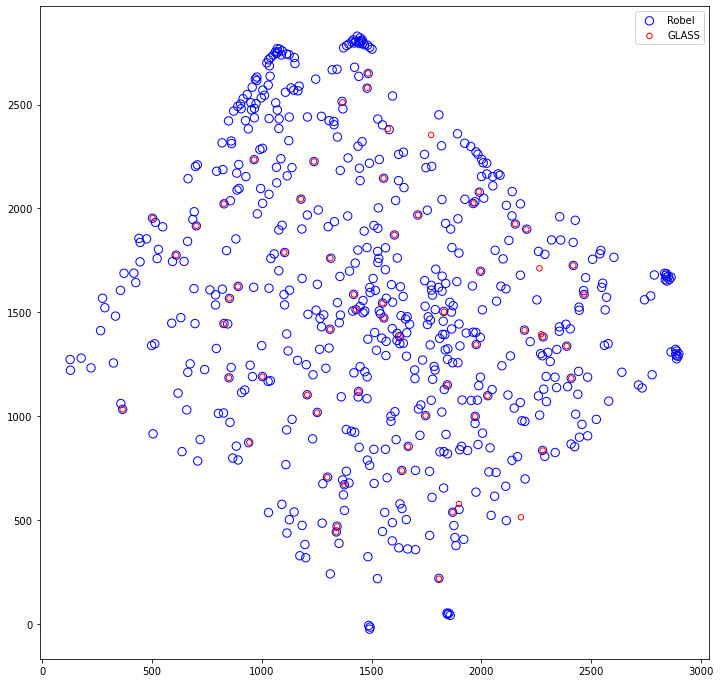

In [42]:
plt.scatter(robel_x, robel_y, s=70, facecolors='none',  edgecolors='Blue', label="Robel")
plt.scatter(glass_x, glass_y, s=30, facecolors='none',  edgecolors='red', label=glass_catalog_name)

#plt.imshow(combined_image.data, vmin=vmin, vmax=vmax)

plt.legend()
#plt.savefig("catalog_compare_overlay.png", dpi=500)
plt.show()


In [43]:
idx, sep2d, dist3d = match_catalogs(glass_ra, glass_dec, robel_ra, robel_dec, unit='deg')

print("arcsec_cutoff:", arcsec_cutoff)
num_matches = np.where(sep2d.to('arcsec').value  < arcsec_cutoff)[0].shape[0]
num_missing = len(glass_catalog) - num_matches

print("Num matchs: {}".format(num_matches))
print("Num missing: {}".format(num_missing))
print("Fraction of matchs: ", num_matches / (num_matches + num_missing))

arcsec_cutoff: 0.5
Num matchs: 58
Num missing: 5
Fraction of matchs:  0.9206349206349206


In [44]:
def glass_to_robel_quality(raw_q):
    if raw_q == [0]:
        return 0
    elif 0 < raw_q <= 2:
        return 1
    elif 2 < raw_q <= 4:
        return 2

# Add matches to redshifts array 
num_added = 0
for i in range(len(idx)):
    robel_i = idx[i]
    
    raw_q = glass_catalog[glass_quality_kwrd][i]
    q = glass_to_robel_quality(raw_q)
    
    if sep2d[i].to('arcsec').value < arcsec_cutoff:
    
        if q > quality[robel_i] and q > 0:
            redshifts[robel_i] = glass_catalog[glass_z_kwrd][i]
            quality[robel_i] = q
            
            num_added += 1 
        
print("Num added: {}".format(num_added))        

Num added: 58


# MUSE

```
Redshift catalog for cluster Abell 2744 (2x2 MUSE mosaic)

Contacts: 
Guillaume Mahler  guillaume.mahler@univ-lyon1.fr
Johan Richard     johan.richard@univ-lyon1.fr

This redshift catalog includes photometrical information based on HST Frontier Fields images.
SExtractor was used to perform the photometry in dual mode: detection was performed on a weighted 
combination of all median-subtracted images(*) and each median-subtracted image was used to measure 
photometry. Magnitudes in the catalog correspond to MAG_ISO value provided by SExtractor. 

ID: SExtractor ID (numbers) or MUSE IDs (starting with "M"). MUSE sources were not detected in the SExtractor 
catalog of the HST images.
RA,DEC: coordinates in degrees (based on the HST Frontier Field images)
Z:  Measured redshift
CONFID: Confidence flag: 1-likely, 2-certain (1 emission line or several faint absorptions), 3-very secure (multiple emissions)
TYPE: Source type (same nomenclature as UDF)
MUL: multiple image system, if multiple. e.g. 33.1 and 33.2 are two images of the same source (system 33).
F435W to F160W, F435W_ERR to F160W_ERR: magnitudes and associated errors
MU and MU_ERR: magnification and associated error. Magnifications values above 30-40 should not be taken at face value as 
a proper computation would be required. Email us if you need one of these specifically.

A special notation is used for magnitudes in the final catalog as follow:

 -> When the magnitude in a filter is fainter than the magnitude limit, the magnitude is replaced 
by the opposite of the magnitude limit. ( e.g.  30.63 => -28.34 ) (the magnitude limit is calculated at 
3 sigma taking the value of the rms map at the location of the object and rescaling it to the isophotal 
area)

 -> According to the SED of each object, when two consecutive points of measurements were separated 
by more than 2 magnitudes a flag of -2 replace the higher values because it's more likely a cosmic 
or defect in the image. These values should be discarded.

 -> When a detection has a magnitude brighter than 25 AND a value of maximum surface brightness minus 
the magnitude (MU_MAX-MAG_ISO) lower than -5.1 the magnitude was also flagged to -2 (this point 
concentrates too much flux in one pixel then is likely a cosmic)

*Preprocessing the HST images with a large scale median filter increases the detection sensitivity to 
sources blended in cluster light.
We subtracted the median  in a running box of 1.26x1.26 arcsec (21x21 pixels) to each of the original 
images in the filters F435W, F606W, F814W, F105W, F125W, F140W and F160W.

Note: very bright or very extended objects become sharper and part of their flux is lost during the process, 
this might lead to a small underestimation of their real magnitude.


```
Table 4 summarises the redshift measurements both for all sources and for the high-confidence (zcon f > 1) sources. There is a clear trend for clusters having shallower MUSE data (e.g., MACS0329, Bullet) to have a lower fraction of secure redshifts (zconf > 1). We present a redshift histogram for all sources in Fig. 8, which is discussed further in Sect. 5. 14% of all red- shift measurements from the MUSE datacubes (and 12% of high confidence detections, with zcon f > 1) are sources purely de-
Richard et al.: MUSE Lensing Clusters survey
  Article number, page 11 of 47
tected from their line emission with muselet, i.e., they cannot be securely associated with an HST source from the photomet- ric catalogs. While the number of such line-only sources in the final catalog strongly depends on the depth of the HST images (which varies from 26-29 AB for a point source depending on the field / filter), we have identified a few such sources even at the depth of the HST FF images (∼ 29 AB). They correspond to high equivalent width Lyman-α emitters, comparable to sources dis- covered in the MUSE deep fields (Bacon et al. 2017; Hashimoto et al. 2017; Maseda et al. 2018). Low-redshift line-only sources are typically associated stripped gas and jellyfish galaxies in the clusters, or high equivalent width emission lines from compact galaxies.


In [46]:
# MUSE 
muse_catalog_path = "https://cral-perso.univ-lyon1.fr/labo/perso/johan.richard/MUSE_data_release/catalogs/RXJ1347_v1.0.fits"
muse_catalog_name = "MUSE A370"

muse_ra_kwrd = "RA"
muse_dec_kwrd = "DEC"
muse_z_kwrd = "z"
muse_quality_kwrd = "zconf"

raw_muse_catalog = Table.read(muse_catalog_path)
print("{}: {}".format(muse_catalog_name, len(raw_muse_catalog)))

MUSE A370: 542


In [49]:
# Filter redshifts
muse_catalog_mask = np.ones((len(raw_muse_catalog))).astype(bool)

muse_catalog_mask = muse_catalog_mask & (raw_muse_catalog[muse_z_kwrd] > min_z).astype(bool).data  
muse_catalog_mask = muse_catalog_mask & (raw_muse_catalog[muse_z_kwrd] < max_z).astype(bool).data 
muse_catalog_mask = muse_catalog_mask & (raw_muse_catalog[muse_z_kwrd] != 0).astype(bool).data 

muse_catalog = raw_muse_catalog[muse_catalog_mask]
print(len(muse_catalog))

298


In [50]:
# Coords 
muse_ra, muse_dec = muse_catalog[muse_ra_kwrd], muse_catalog[muse_dec_kwrd]
muse_x, muse_y = combined_image.wcs.all_world2pix(muse_catalog[muse_ra_kwrd], 
                                                    muse_catalog[muse_dec_kwrd], 0)

robel_ra, robel_dec = robel_cat['ra'], robel_cat['dec']
robel_x, robel_y = combined_image.wcs.all_world2pix(robel_cat['ra'], 
                                                    robel_cat['dec'], 0)

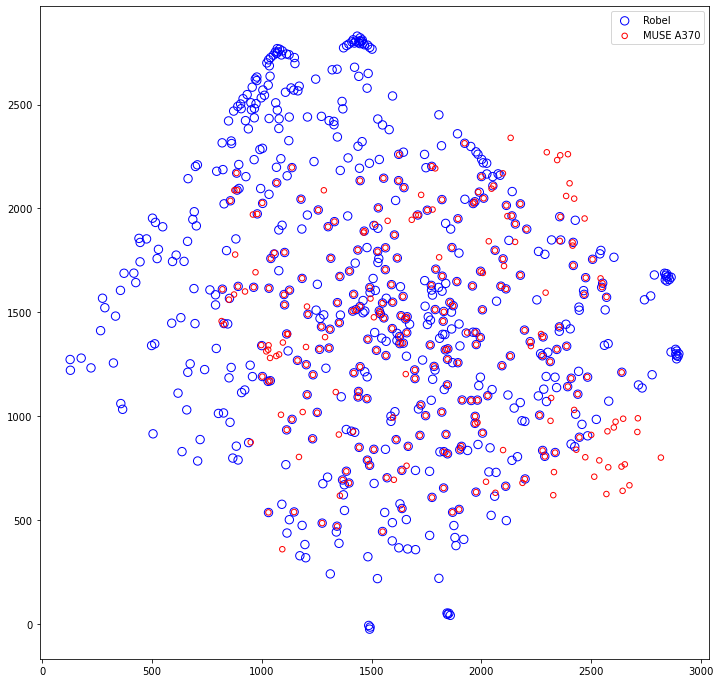

In [51]:
plt.scatter(robel_x, robel_y, s=70, facecolors='none',  edgecolors='Blue', label="Robel")
plt.scatter(muse_x, muse_y, s=30, facecolors='none',  edgecolors='red', label=muse_catalog_name)

#plt.imshow(combined_image.data, vmin=vmin, vmax=vmax)

plt.legend()
#plt.savefig("catalog_compare_overlay.png", dpi=500)

plt.show()

In [52]:
idx, sep2d, dist3d = match_catalogs(muse_ra, muse_dec, robel_ra, robel_dec, unit='deg')

print("arcsec_cutoff:", arcsec_cutoff)
num_matches = np.where(sep2d.to('arcsec').value < arcsec_cutoff)[0].shape[0]
num_missing = len(muse_catalog) - num_matches

print("Num matchs: {}".format(num_matches))
print("Num missing: {}".format(num_missing))
print("Fraction of matchs: ", num_matches / (num_matches + num_missing))

arcsec_cutoff: 0.5
Num matchs: 209
Num missing: 89
Fraction of matchs:  0.7013422818791947


In [53]:
def muse_to_robel_quality(raw_q):
    if raw_q == [0]:
        return 0
    elif 0 < raw_q <= 1:
        return 1
    elif 1 < raw_q <= 3:
        return 2

# Add matches to redshifts array 
num_added = 0
for i in range(len(idx)):
    robel_i = idx[i]
    
    raw_q = muse_catalog[muse_quality_kwrd][i]
    q = muse_to_robel_quality(raw_q)
    
    if sep2d[i].to('arcsec').value < arcsec_cutoff:
        
        if q > quality[robel_i] and q > 0:
            redshifts[robel_i] = muse_catalog[muse_z_kwrd][i]
            quality[robel_i] = q
            
            num_added += 1 
        
print("Num added: {}".format(num_added))        

Num added: 192


# Final Redshift Catalog

In [54]:
num_redshifts_found = len(np.where(~np.isnan(redshifts))[0])

print("Number of redshifts: {}".format(num_redshifts_found))
print("Fraction of photo catalog: {}".format(num_redshifts_found/len(robel_cat)))

Number of redshifts: 224
Fraction of photo catalog: 0.3739565943238731


In [55]:
robel_cat.add_column(redshifts, index=3, name="z")
robel_cat.add_column(quality, index=4, name="z_quality")

In [56]:
robel_cat

label,ra,dec,z,z_quality,maxval_xindex,maxval_yindex,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr,r_petrosian,r_half_light,r_half_light_arcsec,r_total_flux,r_total_flux_arcsec,r20,r80,c2080,f_half_light_f435w,f_half_light_err_f435w,f_total_f435w,f_total_err_f435w,m_half_light_f435w,m_half_light_err_f435w,m_total_f435w,m_total_err_f435w,f_half_light_f475w,f_half_light_err_f475w,f_total_f475w,f_total_err_f475w,m_half_light_f475w,m_half_light_err_f475w,m_total_f475w,m_total_err_f475w,f_half_light_f606w,f_half_light_err_f606w,f_total_f606w,f_total_err_f606w,m_half_light_f606w,m_half_light_err_f606w,m_total_f606w,m_total_err_f606w,f_half_light_f625w,f_half_light_err_f625w,f_total_f625w,f_total_err_f625w,m_half_light_f625w,m_half_light_err_f625w,m_total_f625w,m_total_err_f625w,f_half_light_f775w,f_half_light_err_f775w,f_total_f775w,f_total_err_f775w,m_half_light_f775w,m_half_light_err_f775w,m_total_f775w,m_total_err_f775w,f_half_light_f814w,f_half_light_err_f814w,f_total_f814w,f_total_err_f814w,m_half_light_f814w,m_half_light_err_f814w,m_total_f814w,m_total_err_f814w,f_half_light_f105w,f_half_light_err_f105w,f_total_f105w,f_total_err_f105w,m_half_light_f105w,m_half_light_err_f105w,m_total_f105w,m_total_err_f105w,f_half_light_f125w,f_half_light_err_f125w,f_total_f125w,f_total_err_f125w,m_half_light_f125w,m_half_light_err_f125w,m_total_f125w,m_total_err_f125w,f_half_light_f140w,f_half_light_err_f140w,f_total_f140w,f_total_err_f140w,m_half_light_f140w,m_half_light_err_f140w,m_total_f140w,m_total_err_f140w,f_half_light_f160w,f_half_light_err_f160w,f_total_f160w,f_total_err_f160w,m_half_light_f160w,m_half_light_err_f160w,m_total_f160w,m_total_err_f160w
int64,float64,float64,float64,float64,int64,int64,float64,float64,str4,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
563,206.89157615964334,-11.735355067550307,nan,0.0,1069,2460,1069.4167351588753,2460.0823743415663,None,787,1297,2248,2602,39613.0,11.26575195874769,9.888338504976122,6.515712226629638,0.4791474198913386,-0.44195428,6545.3457,0.0,218865.08,nan,197507.67876075668,nan,6.501300260052011,3.100620124024805,0.20154030806161727,13.002600520104021,0.8451690338067822,1.8003600720144028,5.4010802160432085,2.385606273598312,6855.513948,82.79803106354643,17198.175407,131.14181410595174,16.067606093866896,20.862656117338638,15.06900020562064,20.363353173215508,6825.736431,82.61801517223711,28670.992781,169.3251097179624,16.49550046986689,21.2881873628899,14.937267427466724,20.509070841689816,8467.6585,92.01988100405259,46016.244011,214.51397159858843,16.671672128681603,21.58137629697951,14.833802546996214,20.662441506136815,7744.949735,88.00539605615101,35981.257983,189.6872636288478,16.184060408805664,21.04533366320278,14.516416059714436,20.211511488657166,7517.354325,86.70267772681534,34070.521352,184.58201795407916,15.974818442263315,20.819899718365082,14.334034046329052,19.99950752039795,8228.348072,90.71024237648139,41840.407739,204.54927948785348,16.170945480681286,21.065086299115634,14.405237347241389,20.182232232395684,93773.651496,306.22483

In [57]:
output_cat_name = robel_cat_path.replace("_catalog.csv", "_redshift_catalog.csv")
robel_cat.write(output_cat_name, overwrite=True)
output_cat_name

'hlsp_clash_hst_rxj1347_v1_drz_petrosian_redshift_catalog.csv'

# Other

In [34]:
[i for i in astrodeep_catalog.colnames if 'MAG_' in i]

['MAG_B435',
 'MAG_V606',
 'MAG_I814',
 'MAG_Y105',
 'MAG_J125',
 'MAG_JH140',
 'MAG_H160',
 'MAG_Ks',
 'MAG_IRAC1',
 'MAG_IRAC2']

In [35]:
raw_m_robel = robel_cat["m_total_f105w"]
raw_m_astrodeep = astrodeep_catalog["MAG_Y105"]

idx, sep2d, dist3d = match_catalogs(astrodeep_ra, astrodeep_dec, robel_ra, robel_dec, unit='deg')

astro_deep_idx_mask = np.where(sep2d.to('arcsec').value < 0.1)

m_astrodeep = raw_m_astrodeep[astro_deep_idx_mask]
m_robel = raw_m_robel[idx][astro_deep_idx_mask]

for i in range(len(m_robel)):
    if m_robel[i] == "None":
        m_robel[i] = np.nan 
    
m_robel = np.array(m_robel, dtype=np.float)

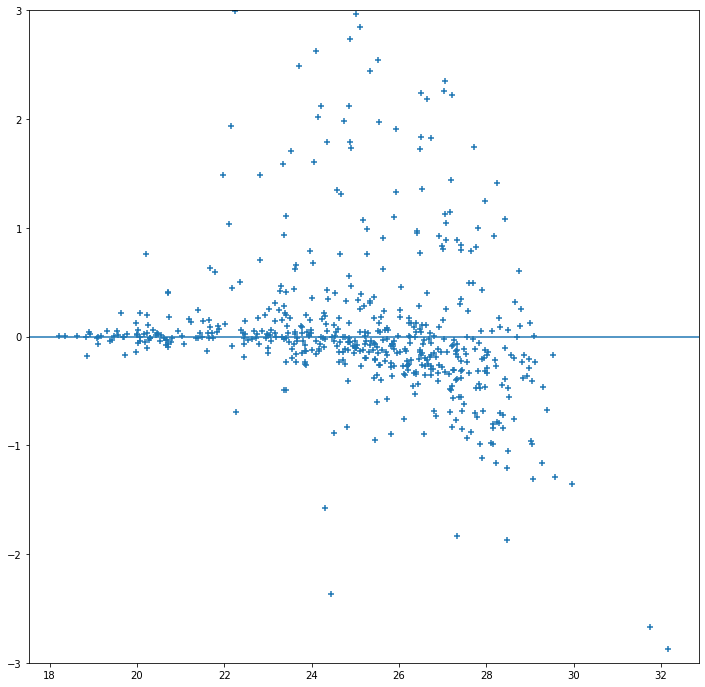

In [36]:
plt.scatter(m_robel, m_astrodeep - m_robel,  marker='+')
plt.ylim(-3,3)
plt.axhline(0)

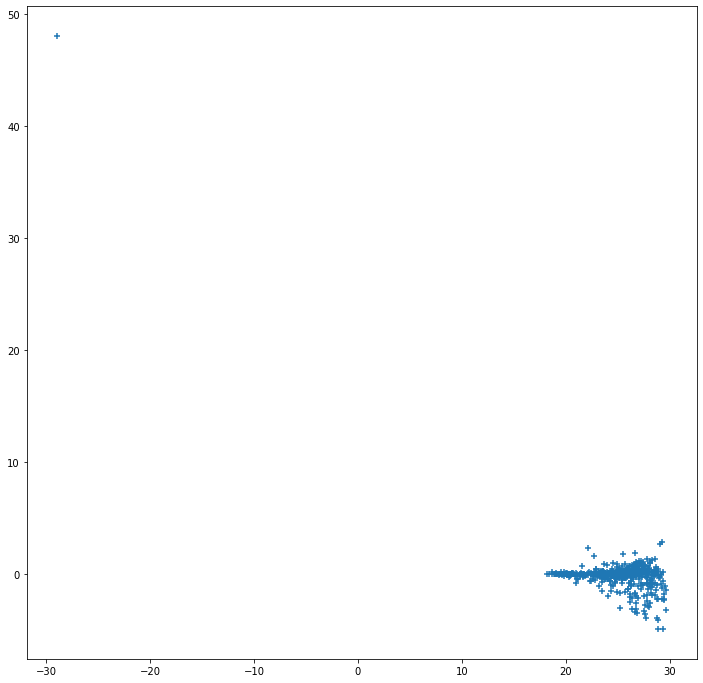

In [37]:
plt.scatter(m_astrodeep, m_robel - m_astrodeep, marker='+')